# Converting `.wav` dataset (train, test, split) to mel-spectrogram `.npy` dataset 

In [4]:
import os
import numpy as np
import librosa
import concurrent.futures
from tqdm import tqdm

In [5]:
def generate_and_save_melspec(source_file, target_file):
    """
    Wczytuje plik MP3 (source_file),
    generuje mel-spektrogram,
    zapisuje do pliku .npy (target_file).
    """
    try:
        y, sr = librosa.load(source_file, sr=None)
        
        # Generowanie mel-spektrogramu
        melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        melspec_db = librosa.power_to_db(melspec, ref=np.max)
        
        # Zapis do pliku npy
        np.save(target_file, melspec_db)
    except Exception as e:
        print(f"[BŁĄD] Przetwarzanie pliku {source_file}: {e}")


def process_folders(source_folder, target_folder, max_workers=4):
    """
    Rekurencyjnie przeszukuje katalog 'source_folder' w poszukiwaniu plików .mp3,
    generuje mel-spektrogram i zapisuje do .npy w strukturze katalogów 'target_folder'.
    
    Wykorzystuje wielowątkowość (ThreadPoolExecutor) i pasek postępu (tqdm).
    """
    
    # Zgromadzimy listę plików (source -> target) do przetworzenia
    tasks = []
    
    for root, dirs, files in os.walk(source_folder):
        # Obliczamy relatywną ścieżkę względem katalogu źródłowego
        relative_path = os.path.relpath(root, source_folder)
        
        # Ścieżka docelowa (ten sam subfolder)
        target_dir = os.path.join(target_folder, relative_path)
        os.makedirs(target_dir, exist_ok=True)

        # Wybieramy pliki mp3 w danym folderze
        mp3_files = [f for f in files if f.lower().endswith('.mp3')]
        
        for filename in mp3_files:
            source_file = os.path.join(root, filename)
            
            # nazwa docelowego pliku (zamieniamy .mp3 -> .npy)
            base_name = os.path.splitext(filename)[0]
            target_file = os.path.join(target_dir, base_name + '.npy')
            
            tasks.append((source_file, target_file))
    
    # Teraz przetwarzamy z użyciem wątków i paska postępu
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # map pozwala nam zrównoleglić generate_and_save_melspec
        # tqdm do paska postępu
        results = list(tqdm(
            executor.map(lambda x: generate_and_save_melspec(x[0], x[1]), tasks),
            total=len(tasks),
            desc="Przetwarzanie plików",
            unit="plik"
        ))
    
    print(f"Zakończono przetwarzanie. Łącznie plików: {len(tasks)}")

In [6]:
source_path = "../../../datasets/jamendo/split_audio_dataset/"
target_path = "../../../datasets/jamendo/split_melspec/"

process_folders(source_path, target_path, max_workers=6)

Przetwarzanie plików: 100%|██████████| 39097/39097 [08:09<00:00, 79.95plik/s] 

Zakończono przetwarzanie. Łącznie plików: 39097


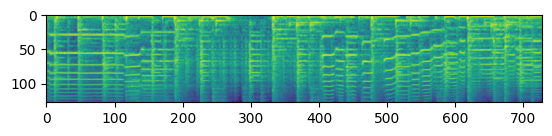

In [10]:
import matplotlib.pyplot as plt
import numpy as np

img_array = np.load("../../../datasets/jamendo/split_melspec/train/00/488400_chunk_5.npy")

plt.imshow(img_array)
plt.show()